<a href="https://www.kaggle.com/code/maksudmalik/quora-question-classification?scriptVersionId=258491550" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings.zip
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/test.csv


In [2]:
import nltk
import xgboost as xgb
import tensorflow as tf
import tensorflow_hub as hub
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from nltk.stem.snowball import SnowballStemmer
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, GRU, Bidirectional, Dense, SimpleRNN, Dropout
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)

# Data Preparation

In [3]:
train_df=pd.read_csv("/kaggle/input/quora-insincere-questions-classification/train.csv")
test_df=pd.read_csv("/kaggle/input/quora-insincere-questions-classification/test.csv")
train_df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [4]:
train_df.shape

(1306122, 3)

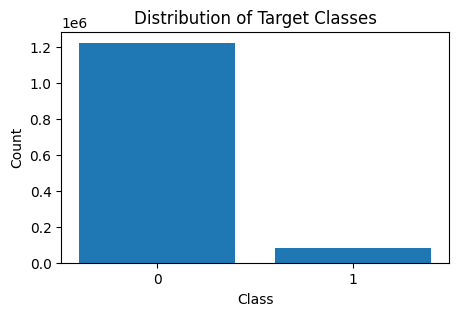

In [5]:
class_counts = train_df["target"].value_counts()
plt.figure(figsize=(5, 3))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Target Classes")
plt.xticks([0, 1])
plt.show()

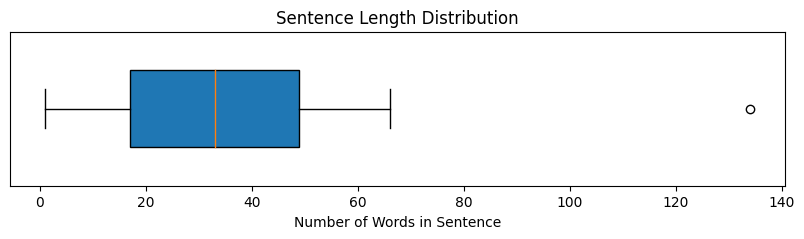

In [6]:
sentence_lengths = [len(sentence.split()) for sentence in train_df.question_text]
length_counts = Counter(sentence_lengths)
lengths = sorted(length_counts.keys())
counts = [length_counts[length] for length in lengths]
plt.figure(figsize=(10, 2))
plt.boxplot(lengths, vert=False, patch_artist=True, widths=0.5)
plt.xlabel('Number of Words in Sentence')
plt.yticks([])
plt.title('Sentence Length Distribution')
plt.show()

In [7]:
train_inputs, val_inputs, y_train, y_val = train_test_split(train_df.question_text, train_df.target, 
                                                                        test_size=0.3, random_state=42)

In [8]:
y_train = y_train.to_numpy()
y_val = y_val.to_numpy()

In [9]:
train_inputs.shape

(914285,)

In [10]:
classes, counts = np.unique(y_train, return_counts=True)
for c, count in zip(classes, counts):
    print(f"Class {c}: {count}")


Class 0: 857339
Class 1: 56946


# Modeling Approaches

## Basic Vector Features (TF-IDF + XGBoost)

In [11]:
english_stopwords = stopwords.words('english')
stemmer = SnowballStemmer(language='english')

In [12]:
def preprocess(doc):
    doc_stp=[[word for word in text.split(" ") if word.lower() not in english_stopwords]for text in doc]
    doc_stem=[[stemmer.stem(word) for word in words]for words in doc_stp]
    doc_final=[' '.join(words) for words in doc_stem]
    return doc_final
    
text_pipeline = Pipeline([
    ('preprocess', FunctionTransformer(preprocess)),
    ('vectorize', TfidfVectorizer(max_features=50000))
])

In [13]:
%%time
x_train=text_pipeline.fit_transform(train_inputs)
x_val=text_pipeline.transform(val_inputs)
x_test=text_pipeline.transform(test_df.question_text)

CPU times: user 3min 20s, sys: 1.77 s, total: 3min 22s
Wall time: 3min 22s


In [14]:
counter = Counter(y_train)
scale_pos_weight = counter[0]/counter[1]
model = xgb.XGBClassifier(
    objective='binary:logistic',
    early_stopping_rounds=20,
    eval_metric='logloss',
    n_estimators=500,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    device = "cuda"
)

In [15]:
%%time
evals = [(x_train, y_train), (x_val, y_val)]
model.fit(x_train, y_train, eval_set=evals, verbose=None)

CPU times: user 16.7 s, sys: 658 ms, total: 17.3 s
Wall time: 14.3 s


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=20,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

Text(0.5, 1.0, 'Logloss over Iterations')

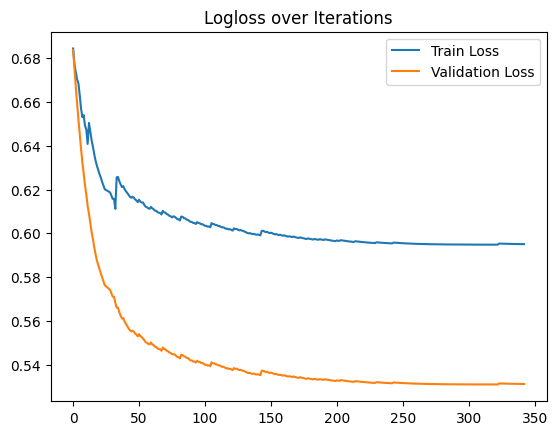

In [16]:
results = model.evals_result()
plt.plot(results['validation_0']['logloss'], label='Train Loss')
plt.plot(results['validation_1']['logloss'], label='Validation Loss')
plt.legend(); plt.title("Logloss over Iterations")

In [17]:
%%time
y_pred=model.predict(x_val)
f1_score(y_val, y_pred)

CPU times: user 757 ms, sys: 2 ms, total: 759 ms
Wall time: 582 ms


0.3671026300743282

## Embedding + SimpleRNN

In [18]:
%%time
vocab = 50000
max_len = 50

tokenizer = Tokenizer(num_words=vocab, oov_token="<OOV>")
tokenizer.fit_on_texts(train_inputs)
sequences_train = tokenizer.texts_to_sequences(train_inputs)

padded_train_inputs = pad_sequences(sequences_train, maxlen=max_len, padding="post")

sequences_val = tokenizer.texts_to_sequences(val_inputs)
padded_val_inputs = pad_sequences(sequences_val, maxlen=max_len, padding="post")

CPU times: user 39.4 s, sys: 198 ms, total: 39.6 s
Wall time: 39.6 s


In [19]:
embedd_size = 50
rnn_units=64
dropout_rate=0.3
model = Sequential([
    Embedding(vocab, embedd_size),
    SimpleRNN(units=rnn_units),
    Dropout(dropout_rate),
    Dense(1, activation="sigmoid")
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [20]:
%%time
model.fit(
    padded_train_inputs, y_train,
    epochs=15, batch_size=256, verbose=1)

Epoch 1/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - accuracy: 0.9420 - loss: 0.1655
Epoch 2/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9551 - loss: 0.1123
Epoch 3/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9584 - loss: 0.1030
Epoch 4/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9630 - loss: 0.0925
Epoch 5/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9663 - loss: 0.0855
Epoch 6/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9685 - loss: 0.0809
Epoch 7/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9649 - loss: 0.1046
Epoch 8/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9378 - loss: 0.2343
Epoch 9/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - accuracy: 0.9379 - loss: 0.2337
Epoch 10/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9418 - loss: 0.2021
Epoch 11/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - accuracy: 0.9594 - loss: 0.1008
Epoch 12/15
3572/35

In [21]:
y_pred=model.predict(padded_val_inputs)
y_pred_binary = (y_pred >= 0.5).astype(int)
f1_score(y_val, y_pred_binary)

12245/12245 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step


0.5944371632445027

## Embedding + Bidirectional LSTM

In [22]:
embedd_size = 50
gru_units = 64
dropout_rate=0.3
GRU_model = Sequential([
    Embedding(vocab, embedd_size), 
    Bidirectional(GRU(gru_units)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])
GRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [23]:
%%time
GRU_model.fit(padded_train_inputs, y_train,
               epochs=15, batch_size=256, verbose=1)

Epoch 1/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.9478 - loss: 0.1431
Epoch 2/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9576 - loss: 0.1033
Epoch 3/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9621 - loss: 0.0927
Epoch 4/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9675 - loss: 0.0810
Epoch 5/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9731 - loss: 0.0677
Epoch 6/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9783 - loss: 0.0556
Epoch 7/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9823 - loss: 0.0460
Epoch 8/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9854 - loss: 0.0374
Epoch 9/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9880 - loss: 0.0314
Epoch 10/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9900 - loss: 0.0264
Epoch 11/15
3572/3572 ━━━━━━━━━━━━━━━━━━━━ 44s 12ms/step - accuracy: 0.9916 - loss: 0.0221
Epoch 12

In [24]:
y_pred=GRU_model.predict(padded_val_inputs)
y_pred_binary = (y_pred >= 0.5).astype(int)
f1_score(y_val, y_pred_binary)

12245/12245 ━━━━━━━━━━━━━━━━━━━━ 36s 3ms/step


0.533439423761464

## Pretrained Transformers (BERT)

In [25]:
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam as TFAdam
from transformers.optimization_tf import AdamWeightDecay

In [26]:
model_checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [27]:
%%time
MAX_LEN=50
encoded_input = tokenizer(
    train_inputs.tolist(),
    max_length=MAX_LEN,
    padding="max_length",
    truncation=True,
    return_tensors="tf"
)

CPU times: user 2min 1s, sys: 11.8 s, total: 2min 12s
Wall time: 46.6 s


In [28]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': encoded_input['input_ids'],
        'attention_mask': encoded_input['attention_mask']
    },
    y_train
)).batch(256).prefetch(tf.data.AUTOTUNE)

In [29]:
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=1)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [30]:
model.compile(
    optimizer=AdamWeightDecay(learning_rate=5e-5),
    loss=BinaryCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [31]:
model.fit(train_dataset, epochs=1)

3572/3572 [==============================] - 2381s 663ms/step - loss: 0.1021 - accuracy: 0.9579


In [32]:
encoded_val_input = tokenizer(val_inputs.to_list(),
    max_length=MAX_LEN,
    padding="max_length",
    truncation=True,
    return_tensors="tf"
                         )

In [33]:
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': encoded_val_input['input_ids'],
        'attention_mask': encoded_val_input['attention_mask']
    },
    y_val
)).batch(256).prefetch(tf.data.AUTOTUNE)

In [34]:
y_pred=model.predict(val_dataset)


1531/1531 [==============================] - 340s 221ms/step


In [35]:
logits = y_pred.logits  
y_pred_binary = (logits >= 0).astype(int).flatten() 
f1 = f1_score(y_val, y_pred_binary)
f1

0.6680221811460259